## Clustering

Before implementing a complex Graph Neural Network (GNN) for unsupervised clustering, I want to clarify the problem, as the current research proposal seems vague. This step will help me understand our current leads and establish solid baselines. I aim for this research to be reproducible and fully open-sourced, facilitating easy use of our codebase and baselines by other researchers trying different methods.

### Settings

1. **Chunk Definition:**
   - A Chunk is a of 100 words.
   - For a book with 160 words, it will be split into: 1 chunk of 100 words each, plus 1 sentence of 60 words.

2. **Data Source:**
   - Using non-biblical Hebrew Qumran scrolls (90 books).

3. **Composition Labels:**
   - A composition is a label consisting of several books together.
   - For example, books 11Q20 and 11Q19 are from the Temple Scroll composition.
   - We currently have 25 unique compositions over 98 books.

4. **Methodology:**
   - **Step 1:** Convert each book into sentences.
   - **Step 2:** Vectorize the text (using n-grams, TF-IDF, Word2Vec, BERT, etc.).

Now we will tackle the following problems:
1. Unsupervised clustering (scroll level) - using Hierarchical Clustering when the objective is the Dasgupta score, scipy.cluster.hierarchy.cophene [ref](https://arxiv.org/pdf/1905.05667), max-dist (ours), 
2. Unsupervised classification (sectarian vs non-sectarian) - using K-means when the objective is adjusted-rand-index, jaccard, nmi, v-measure. **try to answer the question: is the temple scroll is sectarian or not**.
3. Supervised multi-class classification (composition level) - accuracy, precision, recall.
4. Supervised binary classification (sectarian/non sectarian) - accuracy, precision, recall.

under the line:
1. Clustering of Serech Hayachad (חוקים, שירה וכו)
2. Clustering for CD.
3. Check if there different מזמורים in Hodayot.
4. Is Temple Scroll is sectarian?
5. Compare Instruction and Mysteries.
6. Compare pesharim and catena florilegium.


### Reading list
1. [Document Embedding Techniques](https://towardsdatascience.com/document-embedding-techniques-fed3e7a6a25d)
2. Mining text data - book
3. [clustering-sentence-embeddings-to-identify-intents-in-short-text - PRACTICAL](https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e)
4. [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/abs/1908.10084)
5. [Open Intent Discovery through Unsupervised
Semantic Clustering and Dependency Parsing](https://arxiv.org/pdf/2104.12114)
6. [Is Everything in Order? A Simple Way to Order Sentences](https://aclanthology.org/2021.emnlp-main.841.pdf)
7. [The performance of BERT as data representation of text clustering](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-022-00564-9)
8. [Understanding and explaining Delta measures for authorship attribution](https://academic.oup.com/dsh/article/32/suppl_2/ii4/3865676)

Word ordering:
1. [Word Ordering as Unsupervised Learning
Towards Syntactically Plausible Word Representations](https://aclanthology.org/I17-1008.pdf)
2. [UNSUPERVISED ORDER LEARNING](https://openreview.net/pdf?id=1CK45cqkEh)
3. [Graph based Neural Sentence Ordering](https://github.com/DeepLearnXMU/NSEG)
4. [Graph based Neural Sentence Ordering](https://arxiv.org/pdf/1611.02654v2)
5. [A New Sentence Ordering Method Using BERT
Pretrained Model](https://arxiv.org/pdf/2108.11994)
6. https://openreview.net/pdf?id=S1AG8zYeg

Surveys:
1. [Short Text Clustering Algorithms, Application and Challenges: A Survey](https://www.mdpi.com/2076-3417/13/1/342)
2. [Incremental hierarchical text clustering methods: a review](https://arxiv.org/html/2312.07769v1)
3. [A comprehensive survey of clustering algorithms: State-of-the-art machine learning applications, taxonomy, challenges, and future research prospects](https://www.sciencedirect.com/science/article/pii/S095219762200046X)
4. [A Systematic Literature Review on Identifying Patterns Using Unsupervised Clustering Algorithms: A Data Mining Perspective](https://www.mdpi.com/2073-8994/15/9/1679)
5. [Constrained Clustering: Current and New Trends](https://link.springer.com/chapter/10.1007/978-3-030-06167-8_14) - offline

Clustering:
1. [Evaluation of Hierarchical Clustering Algorithms for
Document Datasets∗](https://dl.acm.org/doi/pdf/10.1145/584792.584877)
2. [An Objective for Hierarchical Clustering in Euclidean Space and its Connection to
Bisecting K-means∗](https://arxiv.org/pdf/2008.13235)
3. [Hierarchical Clustering: Objective Functions and Algorithms](https://arxiv.org/pdf/1704.02147)
4. [Evaluation Metrics for Unsupervised Learning
Algorithms](https://arxiv.org/pdf/1905.05667)

Stylometry:
1. [https://pan.webis.de/organization.html](PAN - organiztion fot text forensics)
2. [Surveying Stylometry Techniques and Applications](https://dl.acm.org/doi/10.1145/3132039)
3. Advanced Models for Stylometric Applications - offline
4. [A review on authorship attribution in text mining
](https://wires.onlinelibrary.wiley.com/doi/abs/10.1002/wics.1584)


Graphs:
1. [Graph Embedding Techniques, Applications, and Performance: A Survey](https://arxiv.org/pdf/1705.02801)


TODO:
1. Reading:
    2. EOSL - page 485(504) - unsupervised learning.
    3. Dasgupta - https://arxiv.org/pdf/1510.05043 

In [3]:

import pandas as pd

from config import BASE_DIR
from notebooks.clustering_main import run_clustering_cv
from notebooks.constants import BERT_MODELS
from notebooks.notebooks_utils import set_seed_globaly
from notebooks.plots_utils import create_dasgupta_score_plot
from notebooks.plots_utils import create_lca_metric_boxplot

RERUN = False

In [4]:


clustering_label = "composition"
CHUNK_SIZE = 100
DATA_PATH = f"{BASE_DIR}/notebooks/data/filtered_text_and_starr_features_{CHUNK_SIZE}_words_nonbib_17_06_2024.csv"
df = pd.read_csv(DATA_PATH)
df_grouped = df.groupby("book")["text"].apply(' '.join).reset_index()
book_info = df[["book", "composition", "section", "text_lex"]].drop_duplicates()
df_by_book = pd.merge(df_grouped, book_info, on="book", how="inner").drop_duplicates(["book"])

df_by_book_non_nulls = df_by_book[~(df_by_book[clustering_label].isna())]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 25 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   book                                                                1365 non-null   object 
 1   sentence_path                                                       1365 non-null   object 
 2   text_lex                                                            1362 non-null   object 
 3   text                                                                1365 non-null   object 
 4   n_words_lex                                                         1365 non-null   int64  
 5   n_words                                                             1365 non-null   int64  
 6   construct to absolute nouns ratio                                   1365 non-null   float64
 7   construct nouns

In [6]:
df["book"].unique().shape

(90,)

Our dataset contains chunks of 100 words (using scrolls that have more than 300 words and written in hebrew).
I will use 4 different vectorizers: Starr, trigrams, BERT, tf-idf. When our metric for clustering will be the dgapusta score.

## Hirerchial clustering baseline with different vectorizers

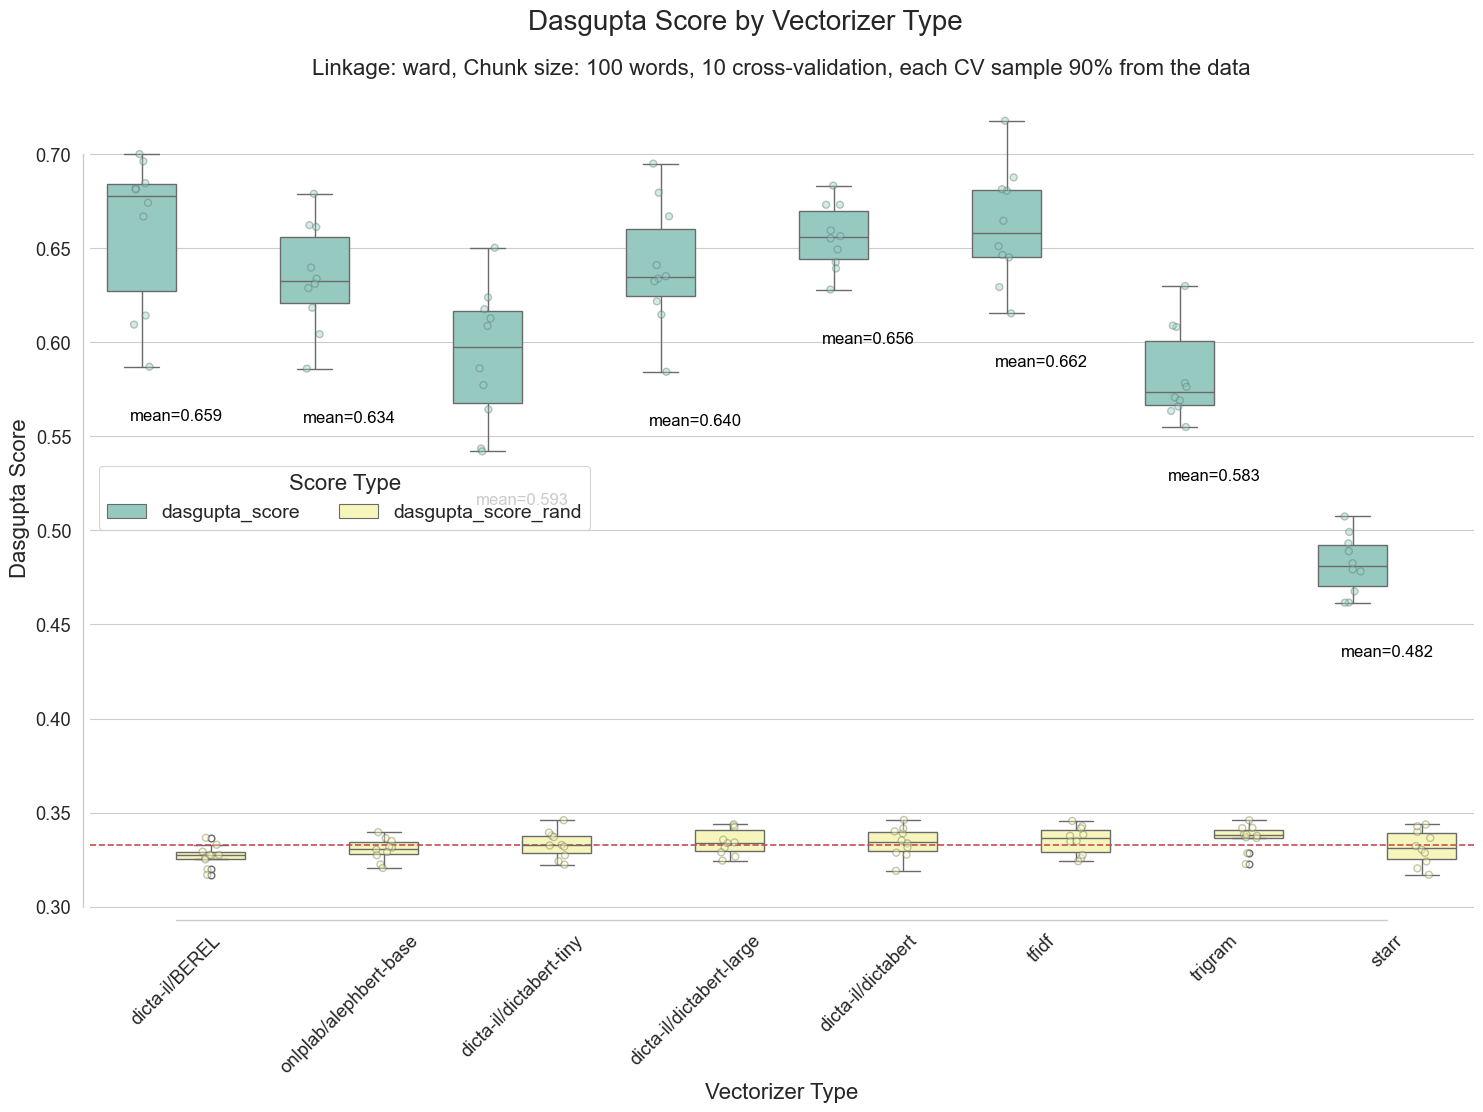

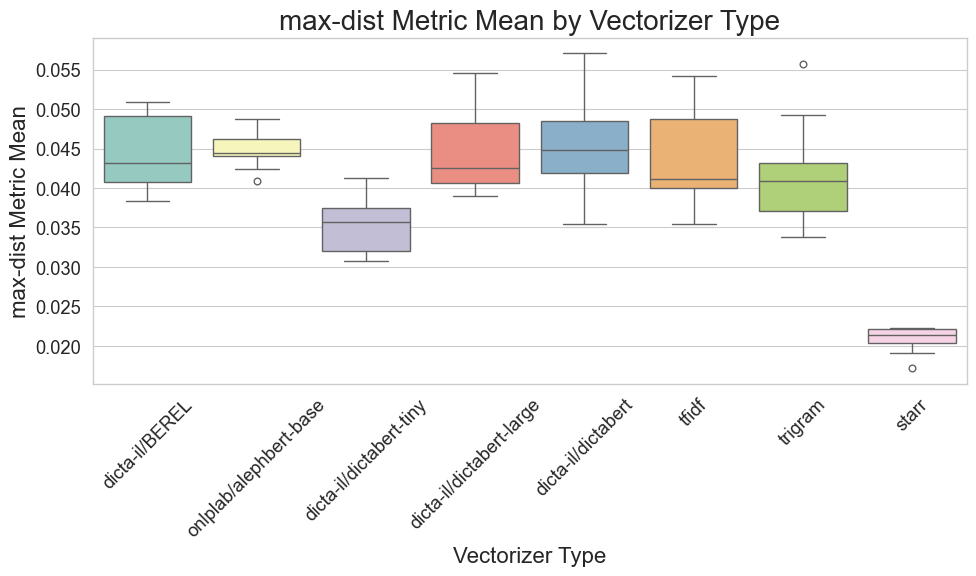

In [5]:


set_seed_globaly()

PATH = f"{BASE_DIR}/notebooks/reports/baselines/hc_baseline_dasgupta"
NUM_CVS = 10
FRAC = 0.9
CONTEXT_SIMILIARITY_WINDOW = 3
vectorizers = BERT_MODELS + ['tfidf', 'trigram', 'starr']
linkage_method = "ward"
file_name = 'dasgupta_scores_window_{}_composition_frac_{}_linkage_{}'.format(CONTEXT_SIMILIARITY_WINDOW,
                                                                              str(FRAC).replace(".", "_"),
                                                                              linkage_method)
if RERUN:
    scores_df = run_clustering_cv(df, FRAC, NUM_CVS, CONTEXT_SIMILIARITY_WINDOW, vectorizers, linkage_method)
    scores_df.to_csv(f"{PATH}/{file_name}.csv", index=False)
else:
    scores_df = pd.read_csv(f"{PATH}/{file_name}.csv")

create_dasgupta_score_plot(scores_df, CHUNK_SIZE, NUM_CVS, FRAC, linkage_method, f"{PATH}/{file_name}",
                           show_p_val=False,
                           p_val_random_test=False, show_mean_scores=True)

create_lca_metric_boxplot(scores_df, f"{PATH}/{file_name}_max_dist")

In [7]:
from notebooks.features import vectorize_text

processed_vectorizers = {}
for vectorizer_type in BERT_MODELS + ['tfidf', 'trigram', 'starr']:
    if vectorizer_type in processed_vectorizers.keys():
        X = processed_vectorizers.get(vectorizer_type)
    else:
        X = vectorize_text(df, "text", vectorizer_type)
        processed_vectorizers[vectorizer_type] = X

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at dicta-il/BEREL and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert:   0%|          | 0/1365 [00:00<?, ?it/s]

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream

bert:   0%|          | 0/1365 [00:00<?, ?it/s]

Some weights of BertModel were not initialized from the model checkpoint at dicta-il/dictabert-tiny and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert:   0%|          | 0/1365 [00:00<?, ?it/s]

Some weights of BertModel were not initialized from the model checkpoint at dicta-il/dictabert-large and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert:   0%|          | 0/1365 [00:00<?, ?it/s]

Some weights of BertModel were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert:   0%|          | 0/1365 [00:00<?, ?it/s]

In [10]:
idx_to_remove_composition = df['composition'].isna()
idx_to_remove_sectarian = (df['section'].isna()) | (df['section'] == "unknown")
processed_vectorizers_comp, processed_vectorizers_sec = {}, {}

for vec_type, vectorizer_mat in processed_vectorizers.items():
    processed_vectorizers_comp[vec_type] = vectorizer_mat[~idx_to_remove_composition]
    processed_vectorizers_sec[vec_type] = vectorizer_mat[~idx_to_remove_sectarian]

In [15]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import plotly.express as px
from warnings import simplefilter
from scipy import sparse as sp
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, jaccard_score
from sklearn.preprocessing import LabelEncoder


def get_clusterer(clustering_algo, n_clusters):
    # Apply the selected clustering algorithm
    if clustering_algo == 'kmeans':
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    elif clustering_algo == 'agglomerative':
        clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    elif clustering_algo == 'dbscan':
        clusterer = DBSCAN(eps=6, min_samples=5)
    else:
        raise ValueError("Unsupported clustering algorithm. Choose from 'kmeans', 'agglomerative', or 'dbscan'.")
    return clusterer


def compute_metrics(processed_vectorizers, vectorizer_type, df, label_column, clustering_algo="kmeans", n_clusters=2):
    vectorizer_matrix = processed_vectorizers.get(vectorizer_type)
    if sp.issparse(vectorizer_matrix):
        vectorizer_matrix = vectorizer_matrix.toarray()
    clusterer = get_clusterer(clustering_algo, n_clusters)

    df['predicted_cluster'] = clusterer.fit_predict(vectorizer_matrix).astype(str)  # Convert labels to strings

    # Compute evaluation metrics
    true_labels = df[label_column]
    le = LabelEncoder()
    le.fit(df[label_column])
    true_labels_encode = le.transform(df[label_column])
    predicted_labels = clusterer.labels_

    ari = adjusted_rand_score(true_labels_encode, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels_encode, predicted_labels)
    fmi = fowlkes_mallows_score(true_labels_encode, predicted_labels)
    jaccard = jaccard_score(true_labels_encode, predicted_labels, average="weighted")
    # jaccard = jaccard_index(true_labels, predicted_labels)

    metrics = {
        'vectorizer_type': vectorizer_type,
        'ari': ari,
        'nmi': nmi,
        'fmi': fmi,
        'jaccard': jaccard
    }

    return metrics


def generate_plots(processed_vectorizers, vectorizer_type, df, label_column, clustering_algo='kmeans', n_clusters=2):
    simplefilter(action='ignore', category=FutureWarning)
    vectorizer_matrix = processed_vectorizers.get(vectorizer_type)
    if sp.issparse(vectorizer_matrix):
        vectorizer_matrix = vectorizer_matrix.toarray()

    clusterer = get_clusterer(clustering_algo, n_clusters)
    df['predicted_cluster'] = clusterer.fit_predict(vectorizer_matrix).astype(
        str)  # Convert labels to strings if needed

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(vectorizer_matrix)

    # Add t-SNE results to the dataframe
    df['tsne-2d-one'] = tsne_results[:, 0]
    df['tsne-2d-two'] = tsne_results[:, 1]

    # Create a facet plot to compare true and predicted labels
    df['label_type'] = 'Predicted'
    true_labels_df = df.copy()
    true_labels_df['predicted_cluster'] = true_labels_df[label_column]
    true_labels_df['label_type'] = 'True'
    combined_df = pd.concat([df, true_labels_df])

    facet_fig = px.scatter(
        combined_df, x='tsne-2d-one', y='tsne-2d-two',
        color='predicted_cluster', facet_col='label_type',
        hover_data={'book': True, label_column: True, "sentence_path": True},
        title=f"t-SNE visualization of clusters: Predicted vs. True ({vectorizer_type}, {clustering_algo})"
    )

    # Update the figure size
    facet_fig.update_layout(
        width=1000,  # Adjust the width as needed
        height=800  # Adjust the height as needed
    )

    facet_fig.update_traces(marker=dict(size=10),
                            selector=dict(mode='markers+text'))
    simplefilter(action='default', category=FutureWarning)
    return facet_fig


## Unsupervised clustering composition level

In [16]:

df_comp = df.dropna(subset="composition")
vectorizer_types = processed_vectorizers_comp.keys()
metrics_list = []

for vectorizer_type in vectorizer_types:
    metrics = compute_metrics(processed_vectorizers_comp, vectorizer_type, df_comp, "composition",
                              clustering_algo="agglomerative", n_clusters=df_comp["composition"].nunique())
    metrics_list.append(metrics)

# Convert metrics list to a DataFrame for easier analysis
metrics_df = pd.DataFrame(metrics_list)
PATH = f"{BASE_DIR}/notebooks/reports/baselines/unsupervised_clustering_composition_level"
metrics_df.to_csv(f"{PATH}/unsupervised_clustering_composition_level.csv", index=False)
metrics_df.sort_values(by=["ari", "jaccard"])



/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_68381/292517552.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_cluster'] = clusterer.fit_predict(vectorizer_matrix).astype(str)  # Convert labels to strings
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_68381/292517552.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_cluster'] = clusterer.fit_predict(vectorizer_matrix).astype(str)  # Convert labels to strings
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m

,vectorizer_type,ari,nmi,fmi,jaccard
7,starr,0.116485,0.310781,0.187350,0.026563
5,tfidf,0.180431,0.518312,0.286090,0.014342
6,trigram,0.219189,0.527181,0.293021,0.005530
3,dicta-il/dictabert-large,0.231377,0.514447,0.284006,0.028684
2,dicta-il/dictabert-tiny,0.239567,0.506478,0.291970,0.045452
0,dicta-il/BEREL,0.264646,0.528527,0.314998,0.005325
1,onlplab/alephbert-base,0.288869,0.538261,0.337811,0.080885
4,dicta-il/dictabert,0.304946,0.561540,0.353257,0.053973


In [17]:
from tqdm.notebook import tqdm
import plotly.io as pio

plots = []

for vectorizer_type in tqdm(vectorizer_types):
    facet_fig = generate_plots(processed_vectorizers_comp, vectorizer_type, df_comp, "composition",
                               clustering_algo="agglomerative", n_clusters=df_comp["composition"].nunique())
    plots.append((facet_fig))

with open(f"{PATH}/clustering_plots.html", "w") as f:
    for i, facet_fig in enumerate(plots):
        html_str = pio.to_html(facet_fig, full_html=False)
        f.write(html_str)
        f.write(f"<hr>Plot {i + 1}<hr>")  # Add a horizontal rule between plots for s


  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_68381/292517552.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_cluster'] = clusterer.fit_predict(vectorizer_matrix).astype(
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_68381/292517552.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tsne-2d-one'] = tsne_results[:, 0]
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_68381/292517552.py:72: SettingWithCopyWarning: 
A value is trying to be set on a co

## Unsupervised clustering for sectarian/non sectarian

In [18]:
vectorizer_types = processed_vectorizers_sec.keys()
sec_df = df[df["section"] != "unknown"].dropna(subset=["section"])

metrics_list = []

for vectorizer_type in vectorizer_types:
    metrics = compute_metrics(processed_vectorizers_sec, vectorizer_type, sec_df, "section",
                              clustering_algo="agglomerative", n_clusters=sec_df["section"].nunique())
    metrics_list.append(metrics)

# Convert metrics list to a DataFrame for easier analysis
metrics_df = pd.DataFrame(metrics_list)
PATH = f"{BASE_DIR}/notebooks/reports/baselines/unsupervised_clustering_sectarian_level"
metrics_df.to_csv(f"{PATH}/unsupervised_clustering_sectarian_level.csv", index=False)
metrics_df.sort_values(by=["ari", "jaccard"])



,vectorizer_type,ari,nmi,fmi,jaccard
0,dicta-il/BEREL,-0.025277,0.002031,0.759421,0.167614
2,dicta-il/dictabert-tiny,-0.002711,0.000026,0.707255,0.240996
6,trigram,-0.001696,0.000027,0.657862,0.530422
4,dicta-il/dictabert,-0.001160,0.000003,0.702342,0.248860
3,dicta-il/dictabert-large,0.005715,0.000273,0.688302,0.273090
1,onlplab/alephbert-base,0.011619,0.000357,0.842997,0.074639
5,tfidf,0.020846,0.016200,0.652962,0.518047
7,starr,0.027775,0.002186,0.866684,0.783905


In [19]:
from tqdm.notebook import tqdm

plots = []

for vectorizer_type in tqdm(vectorizer_types):
    facet_fig = generate_plots(processed_vectorizers_sec, vectorizer_type, sec_df, "section",
                               clustering_algo="agglomerative", n_clusters=sec_df["section"].nunique())
    plots.append((facet_fig))

with open(f"{PATH}/clustering_plots.html", "w") as f:
    for i, facet_fig in enumerate(plots):
        html_str = pio.to_html(facet_fig, full_html=False)
        f.write(html_str)
        f.write(f"<hr>Plot {i + 1}<hr>")  # Add a horizontal rule between plots for s


  0%|          | 0/8 [00:00<?, ?it/s]

In [24]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier


def compute_classification_metrics(model, processed_vectorizers, vectorizer_type, df, label_column):
    # Vectorize the data
    vectorizer_matrix = processed_vectorizers.get(vectorizer_type)

    # Encode the true labels
    le = LabelEncoder()
    df['encoded_labels'] = le.fit_transform(df[label_column])

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        vectorizer_matrix, df['encoded_labels'], test_size=0.3, random_state=42, stratify=df[label_column])

    # Fit the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    metrics = {
        'model': type(model).__name__,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics





## Supervised classification for sectarian/non sectarian

In [25]:

# Define the models and vectorizers to be evaluated
models = [
    RandomForestClassifier(random_state=42),
    LogisticRegression(max_iter=200),
    SVC(),
    KNeighborsClassifier(),
    AdaBoostClassifier(random_state=42),
]
metrics_list = []
vectorizer_types = processed_vectorizers_sec.keys()
# Iterate over each model and vectorizer, compute metrics
for model in tqdm(models, desc="model"):
    for vectorizer_name in tqdm(vectorizer_types, desc="vectorizer"):
        metrics = compute_classification_metrics(model, processed_vectorizers_sec, vectorizer_name, sec_df, "section")
        metrics['vectorizer'] = vectorizer_name
        metrics_list.append(metrics)

# Convert metrics list to a DataFrame for easier analysis
metrics_df = pd.DataFrame(metrics_list)
PATH = f"{BASE_DIR}/notebooks/reports/baselines/sectarian_classification"
metrics_df.to_csv(f"{PATH}/sectarian_classification.csv", index=False)
metrics_df.sort_values(by=["f1_score", "accuracy"], ascending=False)
metrics_df



model:   0%|          | 0/5 [00:00<?, ?it/s]

vectorizer:   0%|          | 0/8 [00:00<?, ?it/s]

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



vectorizer:   0%|          | 0/8 [00:00<?, ?it/s]

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



vectorizer:   0%|          | 0/8 [00:00<?, ?it/s]

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



vectorizer:   0%|          | 0/8 [00:00<?, ?it/s]

vectorizer:   0%|          | 0/8 [00:00<?, ?it/s]

,model,accuracy,precision,recall,f1_score,vectorizer
0,RandomForestClassifier,0.924171,0.930060,0.924171,0.902370,dicta-il/BEREL
1,RandomForestClassifier,0.933649,0.938203,0.933649,0.918240,onlplab/alephbert-base
2,RandomForestClassifier,0.928910,0.934112,0.928910,0.910513,dicta-il/dictabert-tiny
3,RandomForestClassifier,0.933649,0.938203,0.933649,0.918240,dicta-il/dictabert-large
4,RandomForestClassifier,0.938389,0.942334,0.938389,0.925598,dicta-il/dictabert
5,RandomForestClassifier,0.900474,0.810853,0.900474,0.853317,tfidf
6,RandomForestClassifier,0.900474,0.810853,0.900474,0.853317,trigram
7,RandomForestClassifier,0.919431,0.926048,0.919431,0.893763,starr
8,LogisticRegression,0.957346,0.959275,0.957346,0.952023,dicta-il/BEREL
9,LogisticRegression,0.947867,0.945223,0.947867,0.946066,onlplab/alephbert-base


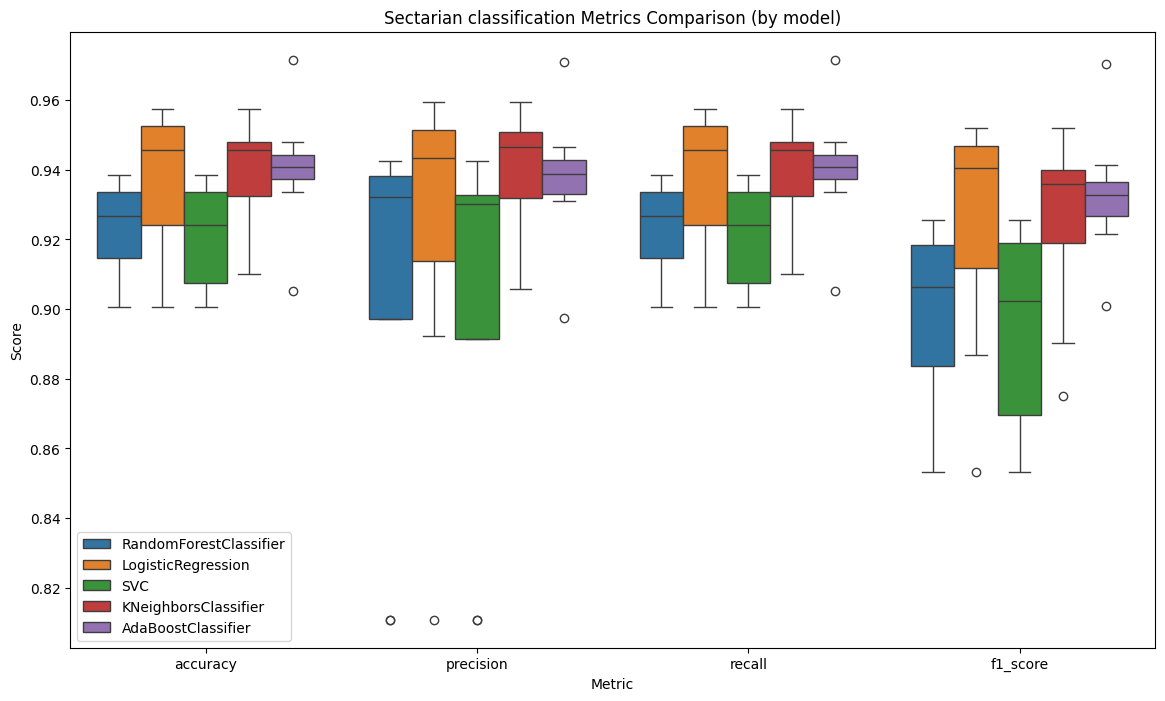

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a box plot for the classification metrics
fig, ax = plt.subplots(figsize=(14, 8))

# Convert metrics_df to long format for better plotting
metrics_long_df = metrics_df.melt(id_vars=['model', 'vectorizer'],
                                  value_vars=['accuracy', 'precision', 'recall', 'f1_score'],
                                  var_name='metric', value_name='score')

# Box plot
sns.boxplot(data=metrics_long_df, x='metric', y='score', hue='model', ax=ax)
ax.set_title('Sectarian classification Metrics Comparison (by model)')
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
plt.legend(loc='best')
plt.savefig(f"{PATH}/classification_metrics_by_model.png")
plt.show()

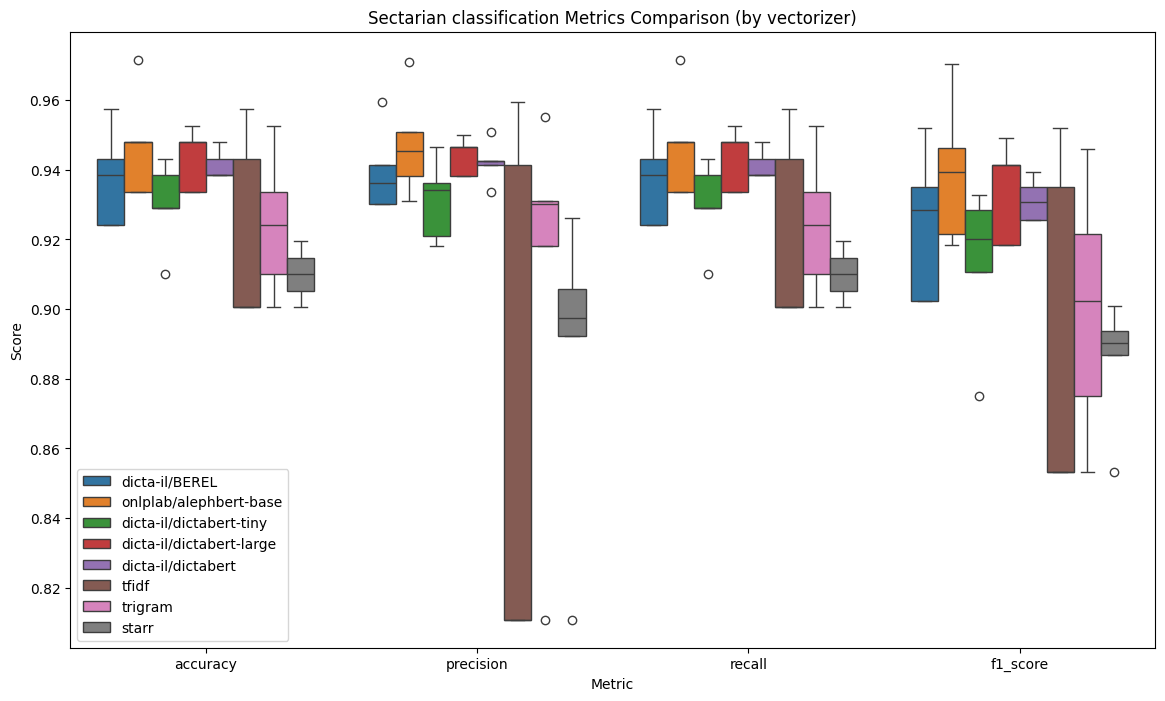

In [23]:

# Creating a box plot for the classification metrics
fig, ax = plt.subplots(figsize=(14, 8))

# Convert metrics_df to long format for better plotting
metrics_long_df = metrics_df.melt(id_vars=['model', 'vectorizer'],
                                  value_vars=['accuracy', 'precision', 'recall', 'f1_score'],
                                  var_name='metric', value_name='score')

# Box plot
sns.boxplot(data=metrics_long_df, x='metric', y='score', hue='vectorizer', ax=ax)
ax.set_title('Sectarian classification Metrics Comparison (by vectorizer)')
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
plt.legend(loc='best')
plt.savefig(f"{PATH}/classification_metrics_by_vectorizer.png")
plt.show()

## Supervised classification for composition

In [27]:

# Define the models and vectorizers to be evaluated
models = [
    RandomForestClassifier(random_state=42),
    LogisticRegression(max_iter=200),
    SVC(),
    KNeighborsClassifier(),
    AdaBoostClassifier(random_state=42),
]
metrics_list = []
vectorizer_types = processed_vectorizers_comp.keys()
# Iterate over each model and vectorizer, compute metrics
for model in tqdm(models, desc="model"):
    for vectorizer_name in tqdm(vectorizer_types, desc="vectorizer"):
        metrics = compute_classification_metrics(model, processed_vectorizers_comp, vectorizer_name, df_comp,
                                                 "composition")
        metrics['vectorizer'] = vectorizer_name
        metrics_list.append(metrics)

# Convert metrics list to a DataFrame for easier analysis
metrics_df = pd.DataFrame(metrics_list)
PATH = f"{BASE_DIR}/notebooks/reports/baselines/composition_classification"
metrics_df.to_csv(f"{PATH}/composition_classification.csv", index=False)
metrics_df.sort_values(by=["f1_score", "accuracy"], ascending=False)
metrics_df



model:   0%|          | 0/5 [00:00<?, ?it/s]

vectorizer:   0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_68381/3189152362.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_68381/3189152362.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

vectorizer:   0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_68381/3189152362.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_clas

vectorizer:   0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_68381/3189152362.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_68381/3189152362.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

vectorizer:   0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_68381/3189152362.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_68381/3189152362.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

vectorizer:   0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_68381/3189152362.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_68381/3189152362.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

,model,accuracy,precision,recall,f1_score,vectorizer
0,RandomForestClassifier,0.577869,0.508769,0.577869,0.509984,dicta-il/BEREL
1,RandomForestClassifier,0.594262,0.553768,0.594262,0.536243,onlplab/alephbert-base
2,RandomForestClassifier,0.602459,0.562076,0.602459,0.545169,dicta-il/dictabert-tiny
3,RandomForestClassifier,0.602459,0.578391,0.602459,0.541469,dicta-il/dictabert-large
4,RandomForestClassifier,0.618852,0.570894,0.618852,0.556700,dicta-il/dictabert
5,RandomForestClassifier,0.577869,0.524838,0.577869,0.511155,tfidf
6,RandomForestClassifier,0.598361,0.531630,0.598361,0.539326,trigram
7,RandomForestClassifier,0.463115,0.411093,0.463115,0.412407,starr
8,LogisticRegression,0.737705,0.724538,0.737705,0.722266,dicta-il/BEREL
9,LogisticRegression,0.704918,0.709060,0.704918,0.695285,onlplab/alephbert-base


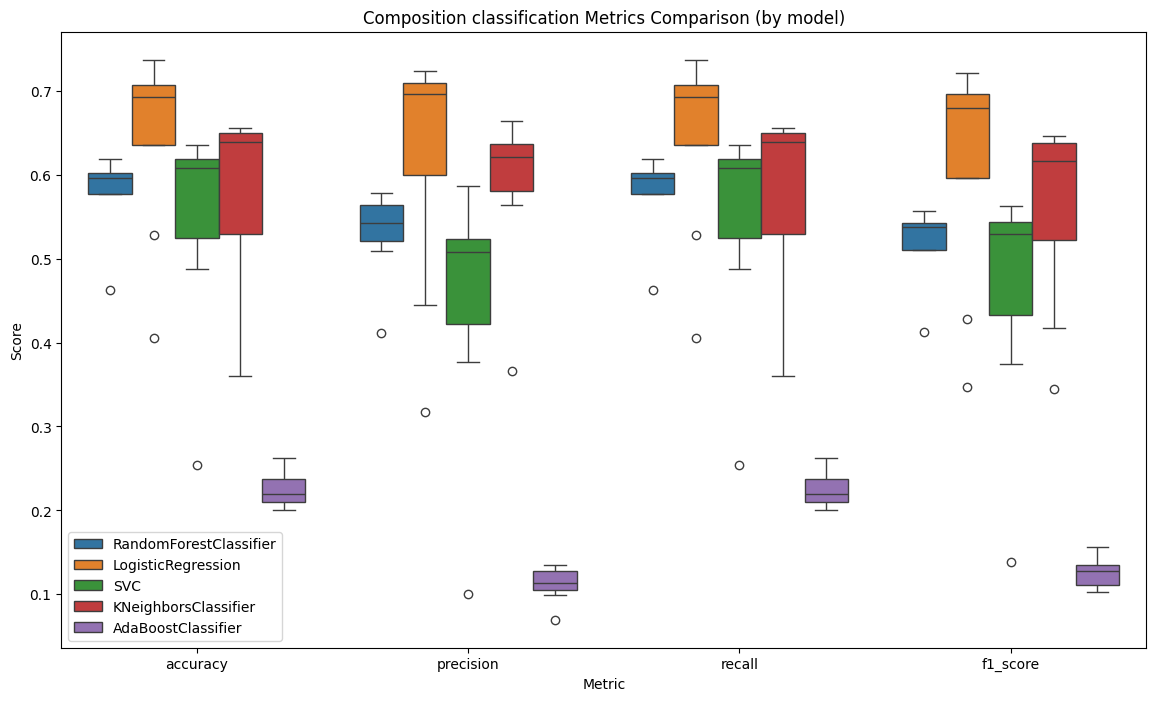

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a box plot for the classification metrics
fig, ax = plt.subplots(figsize=(14, 8))

# Convert metrics_df to long format for better plotting
metrics_long_df = metrics_df.melt(id_vars=['model', 'vectorizer'],
                                  value_vars=['accuracy', 'precision', 'recall', 'f1_score'],
                                  var_name='metric', value_name='score')

# Box plot
sns.boxplot(data=metrics_long_df, x='metric', y='score', hue='model', ax=ax)
ax.set_title('Composition classification Metrics Comparison (by model)')
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
plt.legend(loc='best')
plt.savefig(f"{PATH}/classification_metrics_by_model.png")
plt.show()

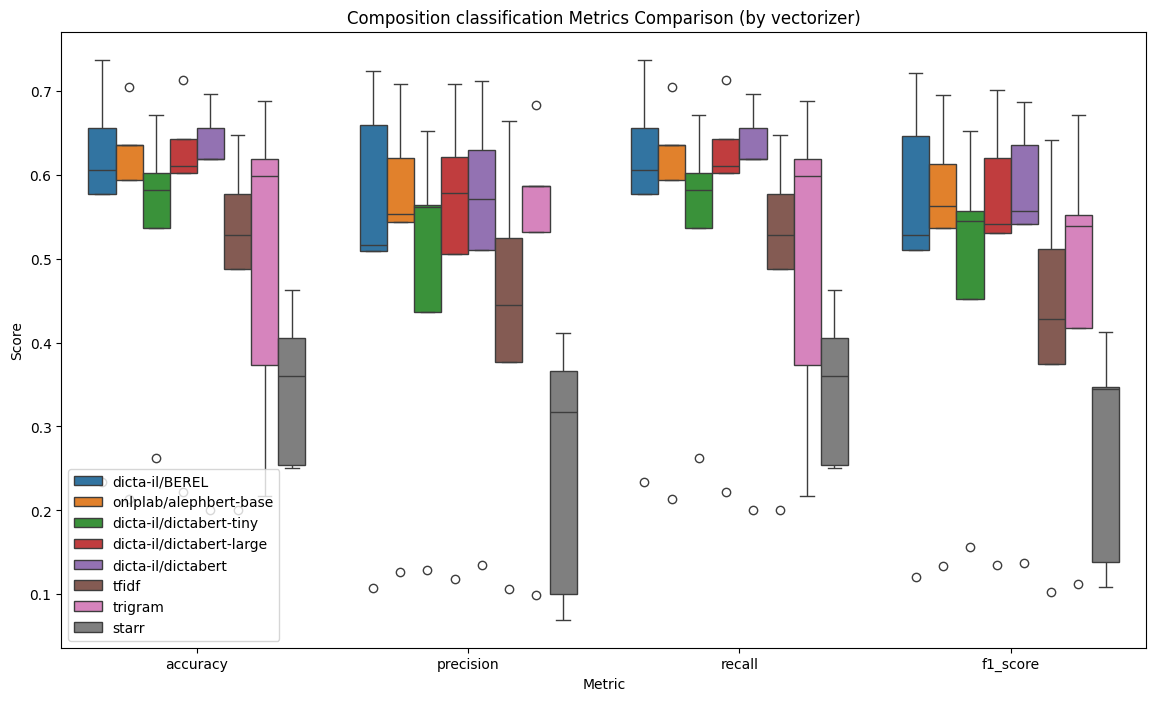

In [29]:

# Creating a box plot for the classification metrics
fig, ax = plt.subplots(figsize=(14, 8))

# Convert metrics_df to long format for better plotting
metrics_long_df = metrics_df.melt(id_vars=['model', 'vectorizer'],
                                  value_vars=['accuracy', 'precision', 'recall', 'f1_score'],
                                  var_name='metric', value_name='score')

# Box plot
sns.boxplot(data=metrics_long_df, x='metric', y='score', hue='vectorizer', ax=ax)
ax.set_title('Composition classification Metrics Comparison (by vectorizer)')
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
plt.legend(loc='best')
plt.savefig(f"{PATH}/classification_metrics_by_vectorizer.png")
plt.show()